In [13]:
import json

import matplotlib
import matplotlib.pyplot as plt
import pyalign
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
from scipy.stats import poisson

from temporal_explanations_4_rl.dataset import (
    load_trajectories,
    load_discrete_actions,
)
from temporal_explanations_4_rl.plan import Plan
from temporal_explanations_4_rl.skill import (
    skill_labels_to_trajectory_skills,
    discrete_policy_distance,
    SkillInstance
)

In [2]:
dataset_folder = "../datasets/rainbow-Breakout"

with open(f"{dataset_folder}/hand-labelled-skills.json") as file:
    data = json.load(file)


num_trajectories = len(data["skill_labels"])
skill_labels = [labels for labels in data["skill_labels"].values()]
actions = load_discrete_actions(
    f"{dataset_folder}/trajectories", num_files=num_trajectories
)
trajectories = load_trajectories(f"{dataset_folder}/trajectories")[:num_trajectories]
assert len(skill_labels) == len(trajectories)
assert all(len(labels) == traj.length for labels, traj in zip(skill_labels, trajectories))
skill_labels = np.concatenate(skill_labels)

skills = skill_labels_to_trajectory_skills(skill_labels, actions, trajectories)
hand_labelled_plan = Plan(skills)

In [3]:
labels = [f"Transition to Skill {j}" for j in range(hand_labelled_plan.unique_skill_types)] + ["Transition to Final Skill"]
colours = list(matplotlib.colors.TABLEAU_COLORS.keys())[:hand_labelled_plan.unique_skill_types + 1]

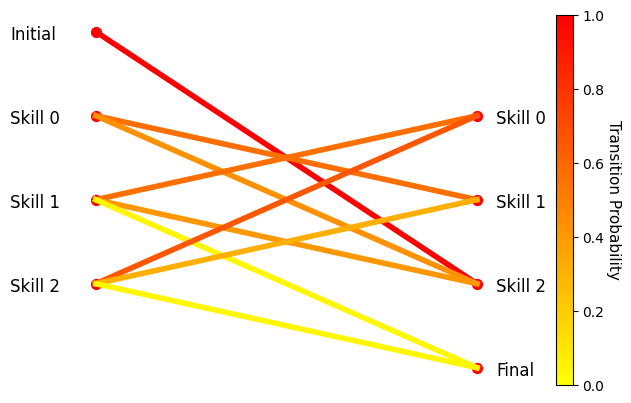

In [4]:
# print(plan.transition_probability)
fig, ax = plt.subplots()
ax.axis("off")

# Draw the nodes
current_skill_nodes = ax.scatter(
    np.full(hand_labelled_plan.unique_skill_types + 1, 1),
    np.arange(1, hand_labelled_plan.unique_skill_types + 2),
    color="red", s=50,
)
next_skill_nodes = ax.scatter(
    np.full(hand_labelled_plan.unique_skill_types + 1, 1.2),
    np.arange(hand_labelled_plan.unique_skill_types + 1),
    color="red", s=50,
)
for i in range(hand_labelled_plan.unique_skill_types):
    ax.text(
        0.955,
        hand_labelled_plan.unique_skill_types - i - 0.09,
        f"Skill {i}",
        color="black",
        fontsize=12,
    )
    ax.text(
        1.21,
        hand_labelled_plan.unique_skill_types - i - 0.09,
        f"Skill {i}",
        color="black",
        fontsize=12,
    )

ax.text(0.955, hand_labelled_plan.unique_skill_types + 1 - 0.09, "Initial", color="black", fontsize=12)
ax.text(1.21, -0.09, "Final", color="black", fontsize=12)

# Draw the transition edges
cmap = plt.cm.autumn_r
norm = matplotlib.colors.Normalize(0, 1)
for i in range(-1, hand_labelled_plan.unique_skill_types):
    for j in range(hand_labelled_plan.unique_skill_types + 1):
        if 0 < hand_labelled_plan.transition_probability[i, j]:
            ax.plot(
                [1, 1.2],
                [hand_labelled_plan.unique_skill_types - i, hand_labelled_plan.unique_skill_types - j],
                color=cmap(norm(hand_labelled_plan.transition_probability[i, j])),
                linewidth=4,
            )

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.6)
cbar = fig.colorbar(sm, cax=cax)
cax.set_ylabel("Transition Probability", rotation=270, labelpad=12, fontsize=11)

# cb.ax.set_yticks(np.linspace(0, 1, 6), label=["0%", "20%", "40%", "60%", "80%", "100%"])
# cb.set_label("Skill Transition Probability", rotation=270)

plt.savefig("figs/quantitative/plan-directed-network-Breakout.pdf")
plt.savefig("figs/quantitative/plan-directed-network-Breakout.png")

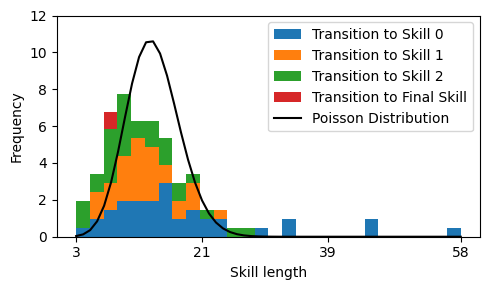

In [38]:
fig, ax = plt.subplots(figsize=(5, 3))

skill_lengths = [np.concatenate(skill_lengths).astype(np.int32) for skill_lengths in hand_labelled_plan.transition_lengths]
concat_skill_lengths = np.concatenate(skill_lengths)
uniques = np.unique(concat_skill_lengths)
lam = np.mean(concat_skill_lengths)

ax.hist(
    skill_lengths, bins=len(uniques),
    stacked=True, fill=True, density=True,
    label=labels, color=colours
)

ax.plot(np.arange(min(uniques), max(uniques) + 1),
        poisson.pmf(np.arange(min(uniques), max(uniques) + 1), lam),
        c="black", label="Poisson Distribution")

# ax.plot(np.linspace(min(lengths), max(lengths), 200), poisson.ppf(np.linspace(min(lengths), max(lengths), 200), mu=lam))
ax.set_xticks(np.linspace(min(uniques), max(uniques), 4, dtype=int))
ticks = ax.get_yticks()
ax.set_yticks(ticks, labels=(len(concat_skill_lengths) * ticks).astype(int))
ax.set_xlabel("Skill length")
ax.set_ylabel("Frequency")

# handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(
    # reversed(handles), reversed(labels),
)
plt.tight_layout()
plt.savefig("figs/quantitative/skill-length-distribution-Breakout.pdf")
plt.savefig("figs/quantitative/skill-length-distribution-Breakout.png")

NameError: name 'hand_labelled_plan' is not defined

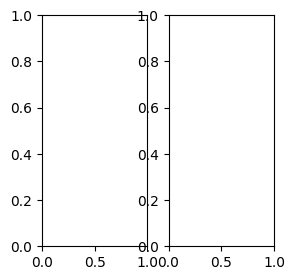

In [39]:
_, axs = plt.subplots(ncols=2, figsize=(3, 3))

pf = pyalign.problems.general(discrete_policy_distance)
solver = pyalign.solve.LocalSolver(
    gap_cost=pyalign.gaps.LinearGapCost(1), codomain=pyalign.solve.Solution
)

def normalised_alignment_metric(skill_1: SkillInstance, skill_2: SkillInstance):
    problem = pf.new_problem(skill_1.actions, skill_2.actions)
    solution: pyalign.solve.Solution = solver.solve(problem)

    return np.max(solution.score) / min(skill_1.length, skill_2.length)


hand_labelled_alignment = np.zeros(shape=(hand_labelled_plan.unique_skill_types, hand_labelled_plan.unique_skill_types))
for i, j in np.ndindex(hand_labelled_alignment.shape):
    skill_pairs = zip(np.random.choice(hand_labelled_plan.skill_instances[i], size=100),
                      np.random.choice(hand_labelled_plan.skill_instances[j], size=100))

    hand_labelled_alignment[i, j] = np.mean([
        normalised_alignment_metric(skill_i, skill_j)
        for skill_i, skill_j in skill_pairs
    ])


# ax.set_title("Similarity between skill")
cb = ax.imshow(hand_labelled_alignment, cmap='autumn_r', origin="lower")
ax.set_yticks(
    np.arange(hand_labelled_plan.unique_skill_types),
    labels=[f"Skill {i}" for i in range(hand_labelled_plan.unique_skill_types)],
)
ax.set_xticks(
    np.arange(hand_labelled_plan.unique_skill_types),
    labels=[f"Skill {i}" for i in range(hand_labelled_plan.unique_skill_types)],
)
for i in range(0, hand_labelled_plan.unique_skill_types - 1):
    ax.axhline(i + 0.5, color="black")
    ax.axvline(i + 0.5, color="black")

# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="7%", pad=0.05)
# cb = plt.colorbar(cb, cax=cax)
# cb.ax.set_yticks(np.linspace(0, 1, 6), label=["0%", "20%", "40%", "60%", "80%", "100%"])
# cb.set_label("Skill Transition Probability", rotation=270)

for i, j in np.ndindex(hand_labelled_alignment.shape):
    ax.text(j, i, f'{hand_labelled_alignment[i, j]:.2f}', ha="center", va="center", color="black", fontsize=12)

plt.tight_layout()
plt.savefig("figs/quantitative/skill-similarity-Breakout.pdf")
plt.savefig("figs/quantitative/skill-similarity-Breakout.png")